# Raman Spectroscopy

This program reads data from Stellarnet Spectrometer and plots it.

    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2024 D.Duke
    @license GPL-3.0+
    @version 0.0.1
    @date 10/11/2025
    
    Multiphase Flow Laboratory
    Monash University, Australia


In [55]:
import numpy as np
import datetime, time, os
from tqdm.notebook import tqdm

In [2]:
import matplotlib.pyplot as plt
%matplotlib widget

## Functions to load and analyse the data

In [39]:
def readStellarNetEPXFile(filename):
    # EPX file is a tab or space seperated array with time snapshots in the columns and wavelength in the rows.
    # Read this into a NumPy array, and parse the header.
    header={}
    timestamps=[]
    time_sec=[]
    data=[]
    with open(filename,'r') as F: # open file
        for line in F.readlines(): # read each line sequentially
            l=line.strip() # remove CR LF
            
            
            if '#' in l:  # Handle comment header
                for headerField in l.strip('#').split(';'): # Convert header to dictionary
                    if '=' in headerField:
                        key,value = headerField.split('=')
                        try:
                            header[key.strip()]=float(value)
                        except ValueError:
                            header[key.strip()]=value.strip()
                    else:
                        header['mode']=headerField.strip()

            
            elif 'wavelength' in l:  # Handle column headers / timestamps
                timestamp_strings = l.split()[1:]
                for t_ in timestamp_strings:
                    timestamps.append( datetime.datetime.strptime(t_,'%Y-%m-%d_%H:%M:%S.%f') ) # full timestamp
                    time_sec.append( timestamps[-1].timestamp() ) # Just absolute seconds
                    
            else: # Handle rest of data
                data.append(l.split()) # save data as list-of-lists initially, we do not know how long it could be.
            
    # When returning result, make `time_sec' relative to the first measurement. `timestamps' is still absolute.
    return header, timestamps, np.array(time_sec) - time_sec[0], np.array(data,dtype=np.float64)

In [35]:
def ramanShift(wavelength, lambda_excitation=532.):
    return 1e7 * ((1./lambda_excitation)-(1./wavelength))

## Main body of code

In [62]:
filename1='/Users/dduke/Desktop/StellarPro Data/Raman/Sprays.EPX'
header1, timestamps1, time_sec1, data1 = readStellarNetEPXFile(filename1)
print("Loaded spectra array of size: %s" % str(data1.shape))

print("\nHeader contains:")
for k in header1.keys(): print('\t',k, header1[k])

# Extract wavelength axis from full data and leave the rest of spectra to plot.
deltaOmega1 = ramanShift(data1[:,0])
spectra1 = data1[:,1:]

Loaded spectra array of size: (2048, 6)

Header contains:
	 mode Scope
	 Time (ms) 5000.0
	 Avg 1.0
	 Sm 2.0
	 Tc 0.0
	 Xt 3.0
	 EP mode Spectrums
	 EP count 5.0
	 EP interval 0.0


In [61]:
# Now get the rest of the data by repeating the above but without printing all the extra info.

filename2='/Users/dduke/Desktop/StellarPro Data/Raman/Sprays.EPX'
header2, timestamps2, time_sec2, data2 = readStellarNetEPXFile(filename2)
deltaOmega2 = ramanShift(data2[:,0])
spectra2 = data2[:,1:]

filename3='/Users/dduke/Desktop/StellarPro Data/Raman/Background.EPX'
header3, timestamps3, time_sec3, data3 = readStellarNetEPXFile(filename3)
deltaOmega3 = ramanShift(data3[:,0])
spectra3 = data3[:,1:]

## Produce results

Plot the raw data, then plot the data all added up with the background removed.

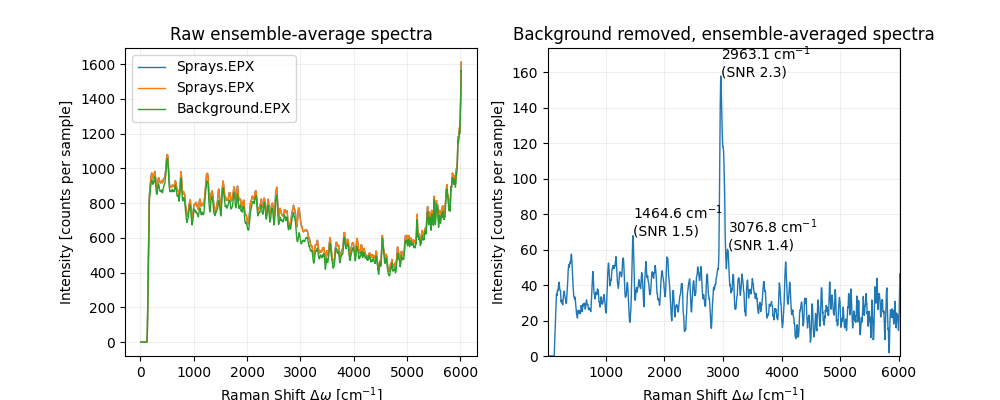

In [144]:
# Plot raw data.

fig=plt.figure(figsize=(10,4))

ax=fig.add_subplot(121)
plt.title('Raw ensemble-average spectra')
plt.xlabel(r'Raman Shift $\Delta \omega$ [cm$^{-1}$]')
plt.ylabel('Intensity [counts per sample]')
plt.grid(alpha=.2)
plt.plot(deltaOmega1, np.nanmean(spectra1,axis=1) , lw=1, label=os.path.basename(filename1))
plt.plot(deltaOmega2, np.nanmean(spectra2,axis=1) , lw=1, label=os.path.basename(filename2))
plt.plot(deltaOmega3, np.nanmean(spectra3,axis=1) , lw=1, label=os.path.basename(filename3))
plt.legend();


# Require the x-axes to match within roundoff, throw error if they do not!
assert(np.all(np.isclose(deltaOmega1,deltaOmega2)))
assert(np.all(np.isclose(deltaOmega1,deltaOmega3))) 

# Sum together SPRAYS and SPRAYS2 and average them with the correct number of realizations in each.
# summation avoids needing to weight the sum of the averages.
ensembleAverage=(np.nansum(spectra1,axis=1)+np.nansum(spectra2,axis=1))/(header1['EP count']+header2['EP count'])

# Remove the background
result = ensembleAverage-np.nanmean(spectra3,axis=1)
noiseFloor = np.median(result)

# Plot with background removed
ax=fig.add_subplot(122)
plt.title('Background removed, ensemble-averaged spectra')
plt.xlabel(r'Raman Shift $\Delta \omega$ [cm$^{-1}$]')
plt.ylabel('Intensity [counts per sample]')
plt.grid(alpha=.2)
plt.plot(deltaOmega1, result , lw=1);
plt.xlim(deltaOmega1.min(),deltaOmega1.max())
plt.ylim(0,1.1*result.max())

# Find any peaks and note them on the plot
sortedByMagnitude=np.argsort(result)[::-1]
peaks=[]
for i in sortedByMagnitude:
    if result[i]>2*noiseFloor: # don't show peaks buried in the noise.
        if len(peaks)>10: break # max 10 peaks.
        elif len(peaks)>0:
            test=np.abs(peaks-i)<=25 # each peak must be at least +/- 25 wavenumber resolution units apart to avoid multi hits.
            if np.any(test): continue

        snr_est = np.sqrt(np.nanmean(result[i])/noiseFloor) # approximate SNR using Poisson statistics
        peaks.append(i)
        plt.annotate('%.1f cm$^{-1}$\n(SNR %.1f)' % (deltaOmega2[i],snr_est), (deltaOmega2[i],result[i]));
        
